In [1]:
import os
import json

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mtgc.ai.preprocessing import CardPreprocessor
from mtgc.ai.dataset import DraftDataset
from mtgc.ai.model import DraftPicker

# Prepare data

In [2]:
draft_data_dtypes_path = "../data/mkm/17lands/draft_data_public.MKM.PremierDraft.columns.json"
draft_data_path = "../data/mkm/17lands/draft_data_public.MKM.PremierDraft.csv"

In [3]:
with open(draft_data_dtypes_path, "r") as f:
    dtypes_dict = json.load(f)

draft_data_df = pd.read_csv(draft_data_path, nrows=1_000_000, dtype=dtypes_dict)

In [4]:
draft_data_df[["user_game_win_rate_bucket", "user_n_games_bucket"]].sample(10)

,user_game_win_rate_bucket,user_n_games_bucket
418292,0.56,10
510154,0.46,100
309252,0.52,100
863314,0.60,100
136889,0.46,500
71093,0.40,10
553311,0.58,100
47294,0.48,100
666796,0.48,100
54717,0.42,10


In [5]:
draft_data_df[["user_game_win_rate_bucket", "user_n_games_bucket"]].describe()

,user_game_win_rate_bucket,user_n_games_bucket
count,999286.000000,1000000.000000
mean,0.531951,95.200405
std,0.083201,114.165761
min,0.000000,1.000000
25%,0.500000,50.000000
50%,0.540000,100.000000
75%,0.580000,100.000000
max,0.860000,1000.000000


In [6]:
draft_data_df["user_game_win_rate_bucket"].quantile(q=0.9)

0.62

<Axes: >

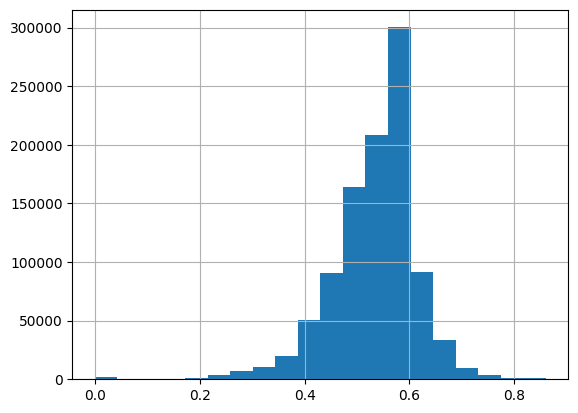

In [7]:
draft_data_df["user_game_win_rate_bucket"].hist(bins=20)

In [8]:
mkm_card_folder = "../data/mkm/cards"

In [9]:
cards_data_dict = {}

for filename in os.listdir(mkm_card_folder):
    file_path = os.path.join(mkm_card_folder, filename)
    card_name = filename.split(".")[0]
    
    with open(file_path, "r") as f:
        card_json_dict = json.load(f)

    cards_data_dict[card_name] = card_json_dict

In [10]:
draft_data_df = draft_data_df[draft_data_df["user_game_win_rate_bucket"] >= 0.62].reset_index(drop=True)

In [11]:
# FIXME: Handle cases like 'Kellan, Inquisitive Prodigy // Tail the Suspect'
draft_data_df = draft_data_df[draft_data_df["pick"].isin(cards_data_dict)].reset_index(drop=True)

In [12]:
pack_columns = [column for column in draft_data_df.columns if "pack_card_" in column]
draft_data_df = draft_data_df[draft_data_df[pack_columns].sum(axis=1) > 1].reset_index(drop=True)

In [13]:
pool_columns = [column for column in draft_data_df.columns if "pool_" in column]
draft_data_df = draft_data_df[draft_data_df[pool_columns].sum(axis=1) > 0].reset_index(drop=True)

In [14]:
draft_data_df.shape

(121675, 666)

In [15]:
card_preprocessor = CardPreprocessor(
    card_type_vocabulary = [
        "Land",
        "Creature",
        "Artifact",
        "Enchantment",
        "Planeswalker",
        "Battle",
        "Instant",
        "Sorcery"
    ],
    keyword_vocabulary = [
        "Attach",
        "Counter",
        "Exile",
        "Fight",
        "Mill",
        "Sacrifice",
        "Scry",
        "Tap",
        "Untap",
        "Deathtouch",
        "Defender",
        "Double strike",
        "Enchant",
        "Equip",
        "First strike",
        "Flash",
        "Flying",
        "Haste",
        "Hexproof",
        "Indestructible",
        "Lifelink",
        "Menace",
        "Protection",
        "Prowess",
        "Reach",
        "Trample",
        "Vigilance"
    ]
)

In [16]:
draft_dataset = DraftDataset(
    draft_data_df=draft_data_df,
    cards_data_dict=cards_data_dict,
    card_preprocessor=card_preprocessor
)

In [17]:
training_draft_dataset, validation_draft_dataset = torch.utils.data.random_split(draft_dataset, [0.8, 0.2])

# Training

In [18]:
n_epochs = 20
n_cumulation_steps = 100
learning_rate = 1e-4

device = torch.device("cuda")

In [19]:
model = DraftPicker(
    input_dim=45,
    transformer_encoder_n_layers=10,
    transformer_encoder_layer_dim=128,
    transformer_encoder_layer_n_heads=8
).to(device)

/home/gcoter/projects/personal/magic-the-gathering-collection/venv/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [20]:
model

DraftPicker(
  (input_mlp): Sequential(
    (0): Linear(in_features=45, out_features=128, bias=True)
    (1): ReLU()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-9): 10 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_mlp): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [21]:
sum(p.numel() for p in model.parameters())

5936257

In [22]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [24]:
training_cumulated_loss = 0.0
n_steps_since_last_cumulation = 0
training_draft_dataset_indices = np.arange(len(training_draft_dataset))
loss_history = {"step": [], "training_loss": []}

In [25]:
model.train()

for n in range(n_epochs):
    print(f"===== Epoch {n + 1}/{n_epochs} =====")
    np.random.shuffle(training_draft_dataset_indices)
    for i, training_draft_dataset_index in enumerate(training_draft_dataset_indices):
        x, y = training_draft_dataset[training_draft_dataset_index]
        x = x.to(device)
        y = y.to(device)
        y_logits = model(x)

        pack_card_mask = x[..., -1].bool()
        y = y[pack_card_mask]
        y_logits = y_logits[pack_card_mask]

        loss = torch.nn.functional.cross_entropy(y_logits, y)
        training_cumulated_loss += loss.cpu().detach().numpy()
        n_steps_since_last_cumulation += 1
        loss.backward()

        if (i > 0 and i % n_cumulation_steps == 0) or (i == len(training_draft_dataset_indices) - 1):
            training_cumulated_loss = training_cumulated_loss / n_steps_since_last_cumulation
            loss_history["step"].append(n * len(training_draft_dataset_indices) + i)
            loss_history["training_loss"].append(training_cumulated_loss)
            print(f"{i}/{len(training_draft_dataset)}: {training_cumulated_loss:.4f}")
            optimizer.step()
            optimizer.zero_grad()
            training_cumulated_loss = 0.0
            n_steps_since_last_cumulation = 0

===== Epoch 1/20 =====
100/97340: 1.4128
200/97340: 1.4257
300/97340: 1.3319
400/97340: 1.3367
500/97340: 1.4059
600/97340: 1.3150
700/97340: 1.4737
800/97340: 1.4119
900/97340: 1.2587
1000/97340: 1.2501
1100/97340: 1.3319
1200/97340: 1.4673
1300/97340: 1.1919
1400/97340: 1.2503
1500/97340: 1.4135
1600/97340: 1.3561
1700/97340: 1.4556
1800/97340: 1.2930
1900/97340: 1.3184
2000/97340: 1.3457
2100/97340: 1.3427
2200/97340: 1.3635
2300/97340: 1.4930
2400/97340: 1.3729
2500/97340: 1.3952
2600/97340: 1.4463
2700/97340: 1.2642
2800/97340: 1.4237
2900/97340: 1.2852
3000/97340: 1.4013
3100/97340: 1.3311
3200/97340: 1.4611
3300/97340: 1.3406
3400/97340: 1.3242
3500/97340: 1.1783
3600/97340: 1.3236
3700/97340: 1.1784
3800/97340: 1.2986
3900/97340: 1.4397
4000/97340: 1.0654
4100/97340: 1.3132
4200/97340: 1.3702
4300/97340: 1.3527
4400/97340: 1.2877
4500/97340: 1.3421
4600/97340: 1.2766
4700/97340: 1.3765
4800/97340: 1.1660
4900/97340: 1.2884
5000/97340: 1.5670
5100/97340: 1.4588
5200/97340: 1.366

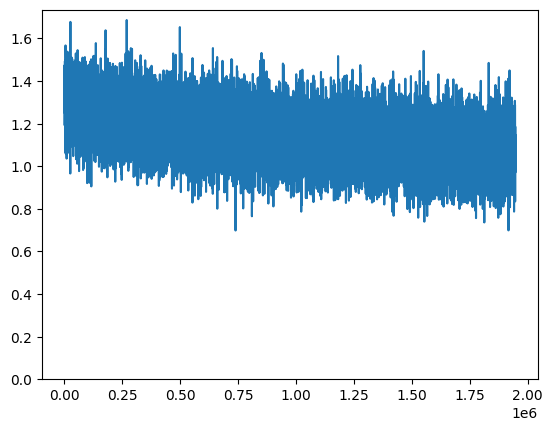

In [26]:
plt.plot(loss_history["step"], loss_history["training_loss"])
plt.ylim(bottom=0.0)
plt.show()

In [27]:
correct_count = 0
random_correct_count = 0
model.eval()

for i, (x, y) in enumerate(validation_draft_dataset):
    if i > 0 and i % 1000 == 0:
        print(f"{i}/{len(validation_draft_dataset)}")

    x = x.to(device)
    y = y.to(device)
    y_logits = model(x)

    pack_card_mask = x[..., -1].bool()
    y = y[pack_card_mask]
    y_logits = y_logits[pack_card_mask]

    if torch.argmax(y_logits) == torch.argmax(y):
        correct_count += 1

    if torch.randint(len(y), size=(1,))[0] == torch.argmax(y):
        random_correct_count += 1

accuracy = 100 * correct_count / len(validation_draft_dataset)
random_accuracy = 100 * random_correct_count / len(validation_draft_dataset)
print(f"Validation Accuracy: {accuracy:.1f}% (random: {random_accuracy:.1f}%)")

1000/24335
2000/24335
3000/24335
4000/24335
5000/24335
6000/24335
7000/24335
8000/24335
9000/24335
10000/24335
11000/24335
12000/24335
13000/24335
14000/24335
15000/24335
16000/24335
17000/24335
18000/24335
19000/24335
20000/24335
21000/24335
22000/24335
23000/24335
24000/24335
Validation Accuracy: 48.0% (random: 18.7%)


In [28]:
torch.save(model.state_dict(), "../models/draft_picker_mkm.pt")